In [4]:
import numpy as np
from keras.applications import VGG16
import keras.backend as K

Using TensorFlow backend.


In [5]:
model = VGG16(include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [6]:
conv_layer_list = [layer for layer in model.layers if 'conv1' in layer.name]

In [42]:
def content_loss(content, transformed):
    return K.sum(K.square(transformed - content))

def gram_matrix(features):
    flat_features = K.batch_flatten(K.permute_dimensions(features, (2, 0, 1)))
    return K.dot(flat_features, K.transpose(flat_features))

def style_loss(style, transformed):
    return K.sum(K.square(gram_matrix(transformed) - gram_matrix(style))) / 1806336

def calc_layer_loss(layer_output, style_coefficient=0.5):
    return (1 - style_coefficient) * content_loss(layer_output[0], layer_output[2]) + style_coefficient * style_loss(layer_output[1], layer_output[2])

In [67]:
def style_transfer(content, style):
    image_tensor = np.stack([content, style, np.random.randn(content.shape[0], content.shape[1], 3)*20 + 128])
    
    input_images = model.input

    loss = K.variable(0.0)
    for layer in conv_layer_list:
        loss += calc_layer_loss(layer.output)

    grads = K.gradients(loss, input_images)[0][2, :, :, :]
    #grads = K.clip(grads, 1e-7, 0.1)
    grads /= K.sqrt(K.mean(K.square(grads)) + 1e-10)
    grads = K.clip(grads, 1e-9, 1e-5)

    iterate = K.function([input_images], [loss, grads])

    for _ in range(20):
        loss, grads = iterate([image_tensor])
        image_tensor[2] -= grads*1e5
        print(loss)
        
    return image_tensor[2]

1.54266e+15
9.00705e+14
5.03591e+14
2.92404e+14
2.88417e+14
2.84755e+14
2.3473e+14
3.05324e+14
2.26765e+14
3.09843e+14
2.45788e+14
3.14741e+14
2.80967e+14
3.36712e+14
3.23934e+14
3.85516e+14
3.67096e+14
4.53285e+14
4.10133e+14
5.06194e+14


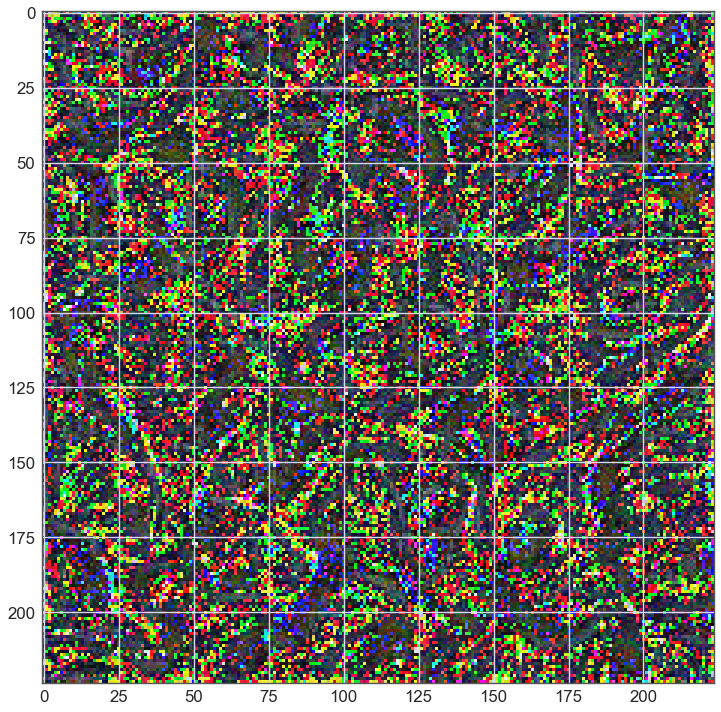

In [68]:
content = imread('data/StyleTransfer/federer.jpg').astype('float32')
style = imread('data/StyleTransfer/starry_night.jpg').astype('float32')
transformed = style_transfer(content, style)
imshow(transformed.astype('uint8'))